<a href="https://colab.research.google.com/github/omkardpatil/conformal_cooling_channels_design_optimization/blob/main/PSO_Rect_FE_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
import fenics
clear_output()

In [7]:
from fenics import *
from mshr import *
from math import *
import os
import numpy as np
import time


temp_threshold_for_fitness=35
temp_threshold_for_stopping=50
t0=0.2 #time for which hot plastic will be in contact
#  Define time things
t_init = 0.0
t_final = 3.0
t_num = 100

def work(mesh, u):
  # Define your mesh and function space
  V = FunctionSpace ( mesh, "Lagrange", 1 )
  # Create a function to interpolate 'u' to the function space
  u_interpolated = interpolate(u, V)
  # Get the values of 'u' at all nodes
  u_values = u_interpolated.vector().get_local()
  np_u = np.array(u_values)
  # Use np.ceil to round up each element to the nearest integer
  integer_array = np.ceil(np_u).astype(int)
  unique_elements, counts = np.unique(integer_array, return_counts=True)
  element_count_dict = dict(zip(unique_elements, counts))
  fitness=0
  j_count=0
  for i, j in element_count_dict.items():
      r=i-temp_threshold_for_fitness
      if(r>0):
          fitness+=(j*j*r)
      j_count+=j
  fitness3 =1-exp(-j_count*5)
  return fitness*fitness3


def heat_implicit (circle):
  circle_x,circle_y,circle_r = circle

  import matplotlib.pyplot as plt


  domain = Rectangle(Point(-1.0,-1.0), Point(1.,1.)) \
        - Circle(Point(circle_x,circle_y),circle_r)
  mesh = generate_mesh ( domain, 10 )
  V = FunctionSpace ( mesh, "Lagrange", 1 )

  rect_u = 150.0
  def rect_on ( x, on_boundary ):
    return ( on_boundary and near(x[1],1))

  rect_bc = DirichletBC ( V, rect_u, rect_on )

  circle_u = 20.0
  def circle_on ( x, on_boundary ):
    r = sqrt ( ( x[0] - circle_x ) ** 2 + ( x[1] - circle_y ) ** 2 )
    return ( on_boundary and ( r < circle_r * 1.1 ) )
  circle_bc = DirichletBC ( V, circle_u, circle_on )
  bc = [ rect_bc, circle_bc ]
  bc_new = [circle_bc]

#  Define the trial functions (u) and test functions (v).
  u = TrialFunction ( V )
  v = TestFunction ( V )


#  The diffusivity is a constant.
  k = Constant ( 1.0 )
#  The source term is zero.
  f = Constant ( 0.0 )
  dt = ( t_final - t_init ) / t_num

#  Create U_INIT.
  u_init = Expression ( "40.0", degree = 10 )
  u_old = interpolate ( u_init, V )
  fvt = ( u_old + dt * f ) * v * dx
  Auvt = u * v * dx + dt * dot ( grad(u), grad(v) ) * dx
  u = Function ( V )
  t = t_init


  for j in range ( 0, t_num + 1):
    t = t + dt
    if(t>t0):
      bc=bc_new
    solve ( Auvt == fvt, u, bc )

    u_old.assign ( u )
    max_value = u.vector().max()
    if(max_value<temp_threshold_for_stopping):
      fitness1 = work(mesh, u)
      fitness2 = exp(t)
      return fitness1*fitness2
  fitness1 = work(mesh, u)
  fitness2 = exp(t)
  return fitness1*fitness2

def heat_implicit_test (circle):
  level = 30
  set_log_level ( level )
  return heat_implicit(circle)

if ( __name__ == '__main__' ):
  #  Define the domain
  circle_x = 0.5
  circle_y = 0.5
  circle_r = 0.25
  circle = [circle_x,circle_y,circle_r]
  ans =heat_implicit_test (circle)
clear_output()

In [8]:
circle_x = 0.5
circle_y = 0.5
circle_r = 0.15
circle = [circle_x,circle_y,circle_r]
heat_implicit_test (circle)

26636.69233244239

49


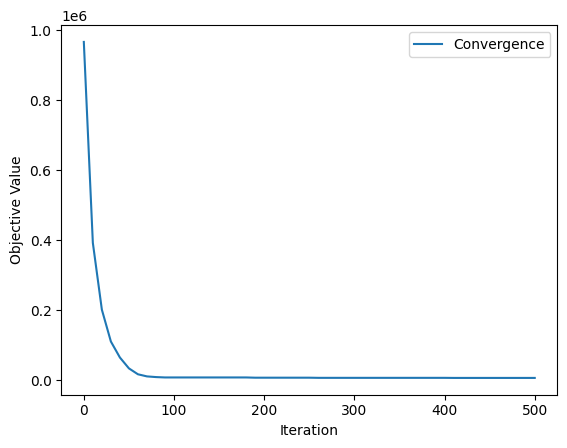

Best Position: [-0.40756129 -0.40700165  0.4       ], Best Value: 7267.469132029718


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Objective function with weight decay (sum of absolute differences)
def objective_function_3d(x):
    ans = heat_implicit_test(x)
    return ans #np.abs(x[0]-0.3) + np.abs(x[1]+0.3) + np.abs(x[2])

# Particle Swarm Optimization function with constraint on x[0]
def particle_swarm_optimization_constrained(objective_function, limits, num_particles=10, num_dimensions=3, num_iterations=100, inertia_weight=0.9, cognitive_param=1.5, social_param=1.5, weight_decay=0.995):

    # Initialize particles within the specified range
    particles_position=np.zeros([num_particles, num_dimensions])
    particles_position[:,0] = np.random.uniform(limits[0][0], limits[0][0], size=(num_particles))
    particles_position[:,1] = np.random.uniform(limits[1][0], limits[1][0], size=(num_particles))

    particles_position[:,2] = np.random.uniform(limits[2][0], limits[2][0], size=(num_particles))
    min_r=0.04
    max_r = np.minimum.reduce([0.4*np.ones(num_particles), 0.95-abs(particles_position[:, 0]),abs(particles_position[:, 0]), abs(particles_position[:, 1]), 0.95-abs(particles_position[:, 1])])
    particles_position[:, 2] = np.clip(particles_position[:, 2], min_r, max_r)



    particles_velocity = np.random.rand(num_particles, num_dimensions)/10
    personal_best_positions = particles_position.copy()
    personal_best_values = np.apply_along_axis(objective_function, 1, personal_best_positions)

    # Global best
    global_best_index = np.argmin(personal_best_values)
    global_best_position = personal_best_positions[global_best_index]
    global_best_value = personal_best_values[global_best_index]

    # Lists to store the history for convergence plot
    convergence_history = [global_best_value]

    # List to store values of x and gb with iterations
    x_list = [particles_position.copy()]
    x_gb_list=[global_best_position.copy()]

    # Particle Swarm Optimization loop
    for _ in range(num_iterations):
        clear_output()
        print(_)
        r1, r2 = np.random.rand(num_particles, 1), np.random.rand(num_particles, 1)
        cognitive_component = cognitive_param * r1 * (personal_best_positions - particles_position)
        social_component = social_param * r2 * (global_best_position - particles_position)
        particles_velocity = inertia_weight * particles_velocity + cognitive_component + social_component
        particles_velocity *= weight_decay
        particles_position += particles_velocity

        # Enforce constraint on x[0]
        particles_position[:, 0] = np.clip(particles_position[:, 0], limits[0][0], limits[0][1])
        particles_position[:, 1] = np.clip(particles_position[:, 1], limits[1][0], limits[1][1])
        min_r=0.04
        max_r = np.minimum.reduce([0.4*np.ones(num_particles), 0.95-abs(particles_position[:, 0]),abs(particles_position[:, 0]), abs(particles_position[:, 1]), 0.95-abs(particles_position[:, 1])])
        particles_position[:, 2] = np.clip(particles_position[:, 2], min_r, max_r)

        current_values = np.apply_along_axis(objective_function, 1, particles_position)
        update_indices = current_values < personal_best_values
        personal_best_positions[update_indices] = particles_position[update_indices]
        personal_best_values[update_indices] = current_values[update_indices]
        global_best_index = np.argmin(personal_best_values)
        global_best_position = personal_best_positions[global_best_index]
        global_best_value = personal_best_values[global_best_index]

        convergence_history.append(global_best_value)
        x_list.append(particles_position.copy())
        x_gb_list.append(global_best_position.copy())

    x_array = np.array(x_list)
    x_gb_array = np.array(x_gb_list)
    x_values = np.arange(len(convergence_history))
    x_values = [x * 10 for x in x_values]


    # Plot the convergence
    plt.plot(x_values, convergence_history, label='Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.legend()
    plt.show()

    return global_best_position, global_best_value, x_array, x_gb_array

# Example usage with constraint on x
n_it=500
limits=[[-0.9, 0.9], [-0.9, 0.9],[0.04, 4]]
best_position, best_value, x_array, x_gb_array = particle_swarm_optimization_constrained(objective_function_3d, limits, num_particles=10, num_iterations=n_it/10)
print(f"Best Position: {best_position}, Best Value: {best_value}")

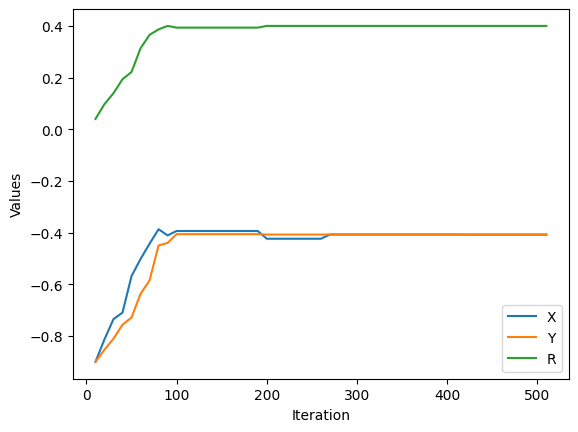

In [27]:
import matplotlib.pyplot as plt

# Assuming u is a list of tuples with x, y, z values
u = x_gb_array

# Extracting x, y, z values
x_values = [point[0] for point in u]
y_values = [point[1] for point in u]
z_values = [point[2] for point in u]

# Generating positions in the list for X-axis
positions = list(range(1, len(u) + 1))
positions = [x * 10 for x in positions]


# Plotting the line plot
plt.plot(positions, x_values, label='X')
plt.plot(positions, y_values, label='Y')
plt.plot(positions, z_values, label='R')

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('Values')
plt.legend()

# Displaying the plot
plt.show()

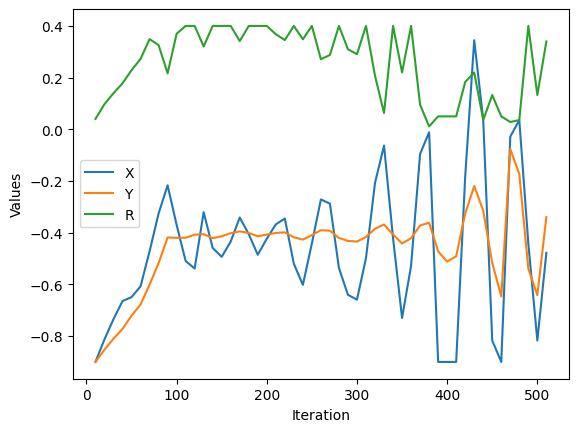

In [30]:
partical_number=5
u = x_array[:,partical_number,:]

import matplotlib.pyplot as plt

# Extracting x, y, z values
x_values = [point[0] for point in u]
y_values = [point[1] for point in u]
z_values = [point[2] for point in u]

# Generating positions in the list for X-axis
positions = list(range(1, len(u) + 1))
positions = [x * 10 for x in positions]

# Plotting the line plot
plt.plot(positions, x_values, label='X')
plt.plot(positions, y_values, label='Y')
plt.plot(positions, z_values, label='R')

# Adding labels and legend
plt.xlabel('Iteration')
plt.ylabel('Values')
plt.legend()

# Displaying the plot
plt.show()